In [117]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from typing import Literal, Callable
from numpy import typing as npt

from smartexp import core

In [118]:
# Aca pongo cuales son realmente los tipos
# No hace falta ponerle el mismo nombre pero es comodo
from typing import Any


from numpy import floating

type ShapeT = tuple[int, ...]
type Param = np.ndarray[tuple[Literal[5], ], np.dtype[np.float64]]
type Control = float
type Output = np.float64
type Data = tuple[list[Control], list[Output]]

type Model = Callable[[Control, Param], Output]

P_NATURE: Param = 1. * np.asarray([1, 2, 3, 4, 5])
DOMAIN = (-100, 100)

def _nature(control: Control) -> Output:
    """The TRUTH about the system.
    """
    return np.polynomial.Polynomial(P_NATURE, domain=DOMAIN)(control)

def _measure(control: Control) -> Output:
    """A REAL measurement (that we simulate for the time being).
    """
    NOISE_CONTROL = 0
    NOISE_MEASURE = 0

    # Sometimes the set control parameter is not properly set.
    control = np.random.normal(control, np.abs(NOISE_CONTROL * control))

    # The output of the system, given the control.
    value = _nature(control)

    # The measured values is not the output of the system
    # but the square of it.
    value = value ** 2

    # The measured values has noise.
    return np.random.normal(value, NOISE_MEASURE * np.abs(value))

def _model(control: Control, params: Param) -> Output:
    """Our model of the system
    """
    return np.polynomial.Polynomial(params, domain=DOMAIN)(control)

def _simulate_measure(control: Control, params: Param) -> Output:
    """Our model of the system and the experiment.
    """
    value = _model(control, params)
    value = value ** 2
    return value

def _update(control: Control, output: Output, data: Data) -> Data:
    data[0].append(control)
    data[1].append(output)
    return data

def _sse(params: Param, model: Model, data: Data) -> floating[Any]:
    c, o = data
    delta = model(np.asarray(c), params) - np.asarray(o)
    return np.mean(delta * delta)

def _fit(model: Model, data: Data, p0: Param) -> tuple[Param, Param] | None:
    res = optimize.minimize(_sse, x0=p0, args=(model, data, ))
    return res.x, np.ones_like(res.x)

def _suggest(model: Model, data: Data, best_params: Param, unc_params: Param) -> Control:
    return np.random.uniform(DOMAIN[0], DOMAIN[1])


class TSE(core.SmartExperiment[Data, Param, Control, Output]):

    measure = staticmethod(_measure)
    simulate_measure = staticmethod(_simulate_measure)
    update = staticmethod(_update)
    fit = staticmethod(_fit)
    suggest = staticmethod(_suggest)

    def __init__(self, p0: Param):
        self.data = ([], [])
        super().__init__(p0)



real params: [1. 2. 3. 4. 5.]
data: ([array(2.)], [1.0841657437958399])
starting params: [0.33867055 0.04285878 0.67968164 0.30155904 0.03184977]
params: [1.11915245 1.66400376 1.97725602 7.24734233 2.93588505]


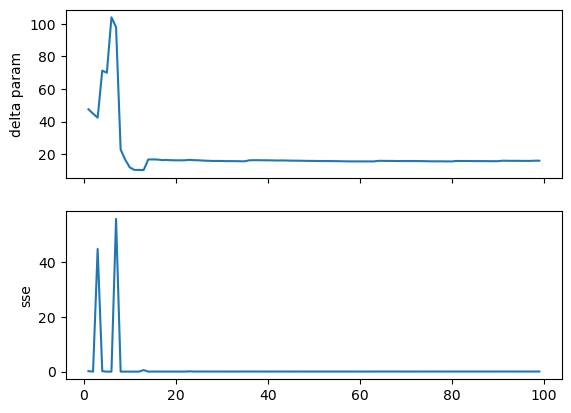

In [119]:
se = TSE(np.random.random(size=P_NATURE.shape))

se.acquire(np.asarray(2.))
print(f"real params: {P_NATURE}")
print(f"data: {se.data}")
print(f"starting params: {se.last_best_params}")

deltas: list[float] = []
sse: list[float] = []

STEPS = np.arange(1, 100)

for n in STEPS:
    # print(f"--- {n:03d} ---")
    se.step()
    # print(f"data: {se.data}")
    # print(f"params: {se.last_best_params}")
    deltas.append(np.sum((se.last_best_params - P_NATURE)**2))
    sse.append(_sse(se.last_best_params, _simulate_measure, se.data))

print(f"params: {se.last_best_params}")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(STEPS, deltas)
ax1.set_ylabel("delta param")
ax2.plot(STEPS, sse)
ax2.set_ylabel("sse")
plt.show()

In [130]:
_fit(_simulate_measure, se.data, np.random.random(size=P_NATURE.shape))

(array([1.00000127, 1.99999985, 2.99999583, 4.00000061, 5.00000271]),
 array([1., 1., 1., 1., 1.]))